# Loading Model and Testing

In [1]:
import sys
import os
import tqdm
import tensorflow as tf
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from importlib import reload

from Base_transformer import TransformerPredictor 
from play_loader import load_play

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)

2025-05-02 17:08:18.045621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 17:08:18.076325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746198498.103463  249732 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746198498.109385  249732 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746198498.132603  249732 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<module 'custom_visualizer' from '/home/sebas/ml/Deep Learning/2025-projects-shallowlearning/code/custom_visualizer.py'>

In [2]:
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
cfg_base = dict(
    num_feats = 46,
    max_len   = 100,
    d_model   = 128,
    n_heads   = 4,       
    n_layers  = 4,      
    d_ff      = 512,     
    dropout   = 0.20,    
)
WEIGHT_FOLDER = Path("../../weights_small_transformer")
#WEIGHT_FOLDER = Path("../../weights")
TRAIN_MODEL   = False         # set True to launch training

In [4]:
EPOCHS = 2000
PATIENCE = 20

if TRAIN_MODEL:
    WEIGHT_FOLDER.mkdir(parents=True, exist_ok=True)
    cmd = (
        "python Base_transformer_trainer.py "
        "--data ../../processed_data/transformer_dataset_9 "
        f"--weights_dir {WEIGHT_FOLDER} "
        "--batch 256 "
        f"--epochs {EPOCHS} "
        f"--patience {PATIENCE} "
        f"--num_feats {cfg_base['num_feats']} "
        f"--max_len {cfg_base['max_len']} "
        f"--d_model  {cfg_base['d_model']} "
        f"--n_heads  {cfg_base['n_heads']} "
        f"--n_layers {cfg_base['n_layers']} "
        f"--d_ff     {cfg_base['d_ff']} "
        f"--dropout  {cfg_base['dropout']} "
        "--mixed_precision mixed_float16 "
        "--plot "
        "--evaluate "
    )
    print("\n⚙️ Launching training:\n", cmd)
    os.system(cmd)

In [5]:
#WEIGHT_PATTERN = "weights/epoch_{:03d}-val{:.4f}.weights.h5"

WEIGHT_FILE = f"{WEIGHT_FOLDER}/best.weights.h5"   # adjust as needed

model = TransformerPredictor(dtype_policy="mixed_float16", **cfg_base)  # or omit arg for fp32
#model = TransformerPredictor()
model.load_weights(WEIGHT_FILE)

model.summary()  # sanity-check layer names/shapes match the notebook

I0000 00:00:1746198502.306404  249732 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9383 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "NFL_Frame_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_xy (Dense)     │ (None, 100, 128)  │      6,016 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_enc             │ (None, 100, 128)  │     12,800 │ proj_xy[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pad_mask            │ (None, 1, 1, 100) │          0 │ cast_1[0][0]      │
│ (PaddingMask)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 100, 128)  │    198,272 │ pos_enc[0][0],    │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 100, 128)  │    198,272 │ functional[0][0], │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 100, 128)  │    198,272 │ functional_1[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 100, 128)  │    198,272 │ functional_2[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_last_hidden  │ (None, 128)       │          0 │ functional_3[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_10 (Cast)      │ (None, 128)       │          0 │ lambda_last_hidd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy (Dense)     │ (None, 46)        │      5,934 │ cast_10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 817,838 (3.12 MB)

 Trainable params: 817,838 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
BATCH_SIZE   = 8
CNTX_SIZE = 80   
N_STEPS = 10

                 # < MAX_LEN just for demo
dummy_seq_batch = tf.random.uniform([BATCH_SIZE, CNTX_SIZE, 46])
dummy_seq = tf.random.uniform([CNTX_SIZE, 46])

y_next = model.predict_next(dummy_seq)  # (46,)
print("Next-frame prediction shape:", y_next.shape) 

y_next_batch = model.predict_next(dummy_seq_batch)      # (8, 46)
print("Next-frame prediction shape:", y_next_batch.shape)

N_FUTRE = 10

y_future = model.predict_autoregressive(dummy_seq, n_steps=N_STEPS)  # (10, 46)
print("Autoregressive rollout shape:", y_future.shape)

y_future_batch = model.predict_autoregressive(dummy_seq_batch, n_steps=N_STEPS)  # (8, 10, 46)
print("Autoregressive rollout shape:", y_future_batch.shape)

2025-05-02 17:08:31.594953: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Next-frame prediction shape: (46,)
Next-frame prediction shape: (8, 46)
Autoregressive rollout shape: (10, 46)
Autoregressive rollout shape: (8, 10, 46)


# Vissualizing

## Test set context, Random start

In [7]:
DATASET_PATH = "../../processed_data/transformer_dataset_9"

def filter_split(split_num):
    def _filter(meta, x, y):
        return tf.equal(meta[2], split_num)
    return _filter

def drop_meta(meta, x, y):
    return x, y

raw_ds = tf.data.Dataset.load(DATASET_PATH)

test_ds  = (raw_ds
            .filter(filter_split(2))
            .shuffle(4096)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE))



Run the cell below predict from a random sample play from the test dataset

context shape: (1, 100, 46)
future   shape: (1, 20, 46)


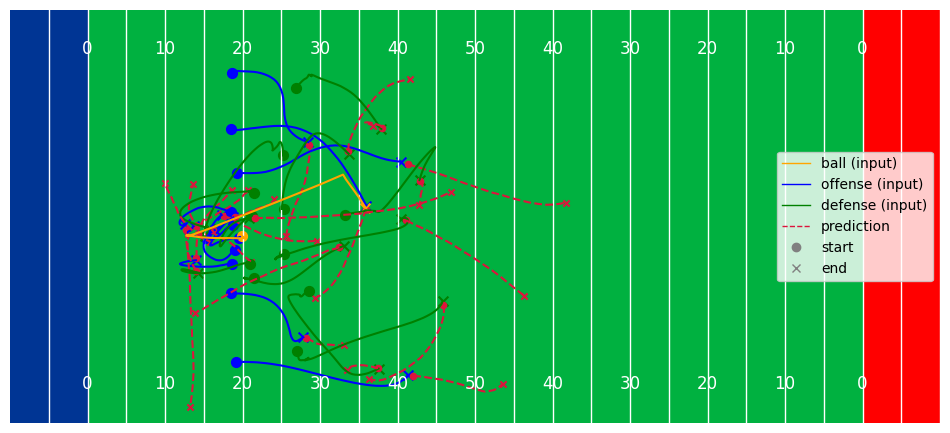

In [8]:
play = next(iter(test_ds))            # a single batch (meta, x, y)

meta, x_ctx, y_next = play            # x_ctx: (1,100,46)"""

N_STEPS = 20
y_future = model.predict_autoregressive(x_ctx, n_steps=N_STEPS)  # (1,100,46)

print("context shape:", x_ctx.shape)
print("future   shape:", y_future.shape)

_ = custom_visualizer.plot_trajectories(
        sequence=x_ctx[0],                 # solid lines:   100-frame context
        offense='all', defense='all', include_ball=True,
        ground_truth_seq=None,
        pred_seq=y_future,       # dashed lines: model rollout
        gt_linestyle='-.', pred_linestyle='--',
        gt_color='limegreen', pred_color='crimson')

## Predict post snap with presnap context

In [ ]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")

df = pd.read_parquet("../../processed_data/model_input_2.parquet")
df = df[['gameId', 'playId']].copy()

game_indexer_test = df.merge(game_indexer, how="left", on=["gameId", "playId"])

#game_indexer_test = game_indexer.loc[game_indexer['split'] == "test", ['gameId', 'playId']].copy()

Run  the cell below to either sample a random play from the dataset, or select your own!

Selected gameId = 2022101000, playId = 573


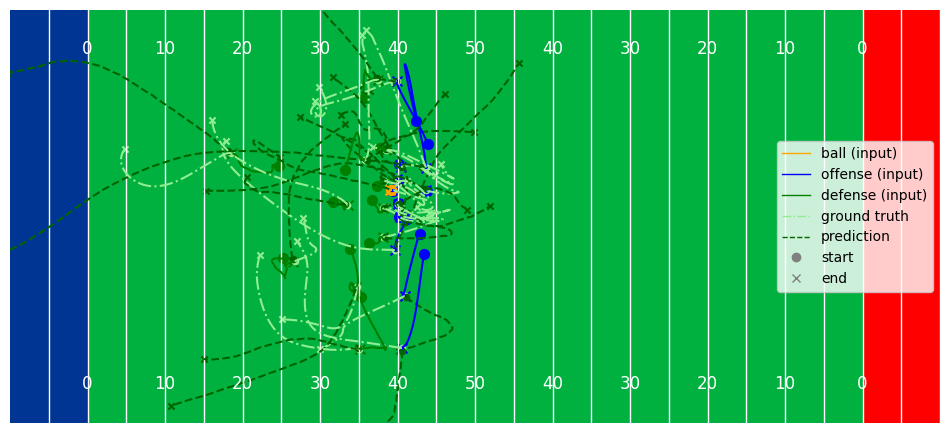

In [10]:
# Filter to test rows and pick one at random
N_STEPS = 50


#################### Samples a random play from the test set #####################
row = game_indexer_test.sample(n=1)  # pick a random row from the test set

gameId = row['gameId'].iloc[0] # Replace with specific gameId if needed
playId = row['playId'].iloc[0] # Replace with specific gameId if needed

###################################################################################

print(f"Selected gameId = {gameId}, playId = {playId}")

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_9.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

################## CHANGE DEPENDING ON MODEL ##################
pred = model.predict_autoregressive(context_seq, n_steps=N_STEPS)
###############################################################

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=gt_future,
        pred_seq=pred,
        offense='all', defense='all', include_ball=True,)

Run the cell below to visualize the visualize the models prediction after snap without the ground truth.

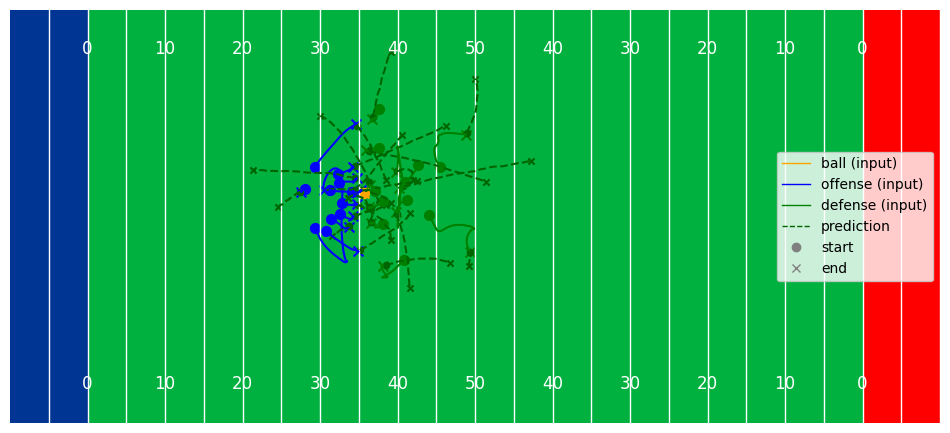

In [11]:
N_STEPS = 30

#################### Samples a random play from the test set #####################
row = (
    game_indexer
    .loc[game_indexer['split'] == "test", ['gameId', 'playId']]
    .sample(n=1) 
)

gameId = row['gameId'].iloc[0] # Replace with specific gameId if needed
playId = row['playId'].iloc[0] # Replace with specific gameId if needed

###################################################################################

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_9.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

pred = model.predict_autoregressive(context_seq, n_steps=N_STEPS)

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=None,
        pred_seq=pred,
        offense='all', defense='all', include_ball=True,)

## Evaluating Model performance with 40 rollout prediction

In [12]:
df = pd.read_parquet("../../processed_data/model_input_2.parquet")
df = df[['gameId', 'playId']].copy()
game_indexer = df.merge(game_indexer, how="left", on=["gameId", "playId"])
game_indexer_test = game_indexer.loc[game_indexer['split'] == "test", ['gameId', 'playId']].copy()

In [13]:
N_STEPS = 40
N_EXAMPLES = 100

# Will hold an (n_plays, N_STEPS) array of L2 errors
all_errors = []

# Loop over every play in the test set
for gameId, playId in tqdm(game_indexer_test.values[:N_EXAMPLES], desc="Evaluating plays"):
    # load context + ground truth future
    context_seq, gt_future = load_play(
        parquet_path="../../processed_data/model_input_2.parquet",
        game_id=gameId,
        play_id=playId,
        ctx_len=100,
        n_future=N_STEPS,
    )

    # Skip if sequence is empty
    if context_seq is None or gt_future is None:
        continue
    # Skip if sequence is all zeros
    if np.all(context_seq == 0) or np.all(gt_future == 0):
        continue
    # Skip if gt_future is less than N_STEPS
    if gt_future.shape[1] < N_STEPS:
        continue

    # Calculate length of the sequence to be predicted
    seq_len = gt_future.shape[1]  # (100, 46)
    
    # autoregressive prediction
    pred = model.predict_autoregressive(context_seq, n_steps=N_STEPS)
    
    # ground-truth for those same steps
    gt = gt_future[0]                                       # (N_STEPS, 46)
    
    # per-frame Euclidean distance (add small eps for stability)
    dists = np.sqrt(np.sum((pred - gt)**2, axis=-1) + 1e-6)  # (N_STEPS,)
    
    all_errors.append(dists)

all_errors = np.stack(all_errors)  # shape = (n_plays, N_STEPS)

# mean error at each future step
mean_error_per_step = all_errors.mean(axis=0)  # (N_STEPS,)

# overall mean error (averaged across all plays & steps)
overall_mean_error = all_errors.mean()

print(f"\nOverall mean Euclidean error (all plays & steps): {overall_mean_error:.4f}")
print(f"\nMultiplied by 120: {overall_mean_error * 120:.4f}")

Evaluating plays: 100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


Overall mean Euclidean error (all plays & steps): 0.3370

Multiplied by 120: 40.4435
